# Project

In this project, we consider the geospatial data.

In [101]:
import osmnx as ox
import numpy as np
import geopandas as gpd
import pandana
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx

## 1. Finding the best location of a new 7-11 franchisee based on existing 7-11 locations and residential buildings (population)

In [102]:
#Test case
G = extract_graph('Macau')
all_schools,all_buildings = extract_schools_buildings('Macau')
school, buildings = generate_case(all_schools,all_buildings,20)
#print(buildings['name'])

2022-05-16 13:29:02 Configured OSMnx 1.1.2
2022-05-16 13:29:02 HTTP response caching is on
2022-05-16 13:29:02 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-16 13:29:02 Created GeoDataFrame with 1 rows from 1 queries
2022-05-16 13:29:02 Constructed place geometry polygon(s) to query API
2022-05-16 13:29:02 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-16 13:29:02 Projected GeoDataFrame to epsg:4326
2022-05-16 13:29:02 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-16 13:29:02 Projected GeoDataFrame to epsg:4326
2022-05-16 13:29:02 Requesting data within polygon from API in 1 request(s)
2022-05-16 13:29:02 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-05-16 13:29:02 Got all network data within polygon from API in 1 request(s)
2022-05-16 13:29:02 Creating graph from downl

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-16 13:29:02 Created graph with 23498 nodes and 29564 edges
2022-05-16 13:29:02 Added length attributes to graph edges
2022-05-16 13:29:02 Identifying all nodes that lie outside the polygon...
2022-05-16 13:29:03 Created nodes GeoDataFrame from graph
2022-05-16 13:29:03 Created r-tree spatial index for 23498 geometries
2022-05-16 13:29:03 Identified 22820 geometries inside polygon
2022-05-16 13:29:03 Removed 678 nodes outside polygon
2022-05-16 13:29:03 Truncated graph by polygon
2022-05-16 13:29:03 Begin topologically simplifying the graph...
2022-05-16 13:29:04 Identified 3456 edge endpoints
2022-05-16 13:29:04 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-05-16 13:29:04 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-05-16 13:29:04 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-05-16 13:29:04 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-05-16 13:29:04 Found 2 edges between 1832146673

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-16 13:29:05 Identified 40 geometries inside polygon
2022-05-16 13:29:05 0 geometries removed by the polygon filter
2022-05-16 13:29:05 0 geometries removed by the tag filter
2022-05-16 13:29:05 40 geometries in the final GeoDataFrame
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022-05-16 13:29:05 Created nodes GeoDataFrame from graph
2022

In [103]:
def extract_graph(place='Macau'):
    ox.config(log_console=True, use_cache=True)
    G = ox.graph_from_place(place, network_type='drive')
    return G
    
def extract_schools_buildings(place='Macau'):
    ox.config(log_console=True, use_cache=True)
    tags = {'building': ['residential']}
    all_buildings = ox.geometries_from_place(place, tags=tags)
    #we only interested in building names and it's geometric information
    all_buildings = all_buildings[['name','geometry']]
    all_buildings = all_buildings[~(all_buildings['name'].isnull())]
    all_buildings = all_buildings[~(all_buildings['geometry'].isnull())]
    all_buildings['center'] = gpd.points_from_xy(x= all_buildings['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_buildings['geometry'].bounds[['miny','maxy']].mean(axis=1))
#     print("*"*50, len(all_buildings))
#     print("*"*50, all_buildings)
    
    tags = {'name': ['7-Eleven']}
    all_schools = ox.geometries_from_place(place, tags=tags)
    all_schools = all_schools[~(all_schools['name'].isnull())]
    all_schools = all_schools[~(all_schools['geometry'].isnull())]
    all_schools['center'] = gpd.points_from_xy(x= all_schools['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_schools['geometry'].bounds[['miny','maxy']].mean(axis=1))
#     print("*"*50, len(all_schools))
#     print("*"*50, all_schools)
    return all_schools,all_buildings

def generate_case(all_schools,all_buildings,n=20):
    school = all_schools.sample(1).iloc[0]
    node_school  = ox.distance.nearest_nodes(G,X=school['center'].x,Y = school['center'].y)
    #print("node_school", node_school)
    buildings = all_buildings.sample(1)
    while True:
        tmp = buildings.iloc[-1]
        node_building = ox.distance.nearest_nodes(G,X = tmp['center'].x,Y = tmp['center'].y)
        if not (nx.has_path(G,node_school,node_building) and nx.has_path(G,node_building,node_school)):
            buildings.drop(buildings.tail(1).index,inplace=True)
        if len(buildings)>=n:
            break
        buildings = pd.concat([buildings,all_buildings.sample(1)])
    print("len(buildings), n", len(buildings), n)
    print("node_building", node_building)
    
    return school, buildings


In [104]:
#Test case
G = extract_graph('Macau')
all_schools,all_buildings = extract_schools_buildings('Macau')

print("."*50, all_schools)
node_schools  = ox.distance.nearest_nodes(G,X=all_schools['center'].x,Y = all_schools['center'].y)
print("/"*50, node_schools)

print("."*50, all_buildings)
node_buildings  = ox.distance.nearest_nodes(G,X=all_buildings['center'].x,Y = all_buildings['center'].y)
print("/"*50, node_buildings)

# all_schools = all_schools.sample(1)
# print("^"*50, all_schools.iloc[0])
# print("&"*50, all_schools.iloc[-1])
# school = all_schools
# print("-"*50, school)
#school, buildings = generate_case(all_schools,all_buildings,20)
#print(buildings['name'])

2022-05-16 13:29:05 Configured OSMnx 1.1.2
2022-05-16 13:29:05 HTTP response caching is on
2022-05-16 13:29:05 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-16 13:29:05 Created GeoDataFrame with 1 rows from 1 queries
2022-05-16 13:29:05 Constructed place geometry polygon(s) to query API
2022-05-16 13:29:05 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-16 13:29:05 Projected GeoDataFrame to epsg:4326
2022-05-16 13:29:05 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-16 13:29:05 Projected GeoDataFrame to epsg:4326
2022-05-16 13:29:05 Requesting data within polygon from API in 1 request(s)
2022-05-16 13:29:05 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-05-16 13:29:05 Got all network data within polygon from API in 1 request(s)
2022-05-16 13:29:05 Creating graph from downl

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-16 13:29:06 Created graph with 23498 nodes and 29564 edges
2022-05-16 13:29:06 Added length attributes to graph edges
2022-05-16 13:29:06 Identifying all nodes that lie outside the polygon...
2022-05-16 13:29:06 Created nodes GeoDataFrame from graph
2022-05-16 13:29:07 Created r-tree spatial index for 23498 geometries
2022-05-16 13:29:07 Identified 22820 geometries inside polygon
2022-05-16 13:29:07 Removed 678 nodes outside polygon
2022-05-16 13:29:07 Truncated graph by polygon
2022-05-16 13:29:07 Begin topologically simplifying the graph...
2022-05-16 13:29:07 Identified 3456 edge endpoints
2022-05-16 13:29:07 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-05-16 13:29:07 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-05-16 13:29:08 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-05-16 13:29:08 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-05-16 13:29:08 Found 2 edges between 1832146673

2022-05-16 13:29:08 Created nodes GeoDataFrame from graph
////////////////////////////////////////////////// [2169023906, 6040835453, 5543335567, 2157625970, 2027444154, 1793358410, 9004853901, 2486214926, 1867326940, 1846288224, 1754036977, 1758262871, 1754056425, 1754056421, 9519277096, 1754036975, 1937893684, 1941039624, 1942400761, 1942810205, 3536417231, 2168717760, 3121609540, 6308719038, 1846266736, 3121665344, 1942810197, 1449241485, 1449241483, 1846195341, 3355823826, 3109979756, 5105836446, 1809540500, 6361766988, 1942467224, 1937893685, 1754056408, 9026600201, 1938179570]
..................................................                                                                 name  \
element_type osmid                                                     
way          192179923                              壹號湖畔 One Central   
             192179943                                     東南亞花園(A座)   
             192179948                               第四座環澳軒 Bloco IV   

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-16 16:41:52 Begin plotting the graph...
2022-05-16 16:41:52 Created edges GeoDataFrame from graph


/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-16 16:41:52 Created nodes GeoDataFrame from graph
2022-05-16 16:41:52 Finished plotting the graph


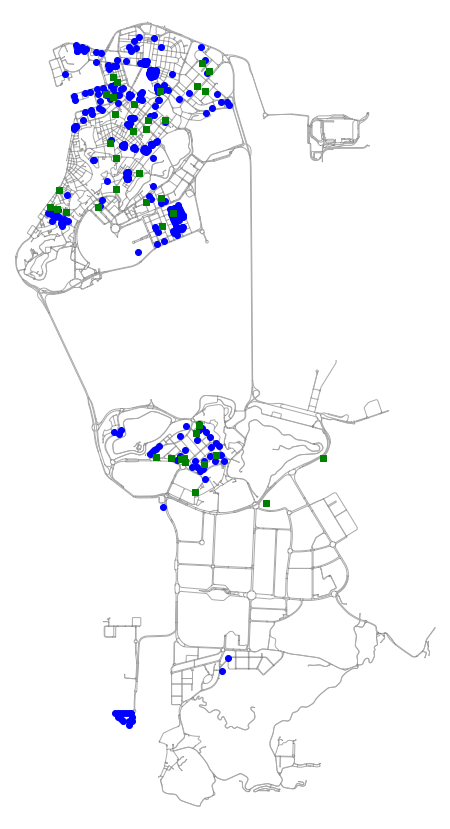

In [122]:
# school = all_schools.sample(10).iloc[0]
# buildings = all_buildings.sample(10).iloc[0]

# fig , ax = ox.plot_graph(G, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
# ax.scatter(all_schools['center'].x,all_schools['center'].y,c='g',marker="s",alpha=1,zorder=4)
# ax.scatter(all_buildings['center'].x,all_buildings['center'].y,c='blue',alpha=1,zorder=3)

# ax.scatter(all_buildings['center'].x, all_buildings['center'].y, c='blue',            alpha=1,zorder=3)
#display(fig)

# ax=all_schools.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
# ax=ox.plot_graph(G, ax=ax, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa")
# ax=all_buildings.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
# ax=ox.plot_graph(G, ax=ax, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa")


# ax=all_buildings.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
# fig,ax=ox.plot_graph(G, ax=ax, figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
ax.scatter(all_schools['center'].x,   all_schools['center'].y,   c='g',    marker="s",alpha=1,zorder=4)
ax.scatter(all_buildings['center'].x, all_buildings['center'].y, c='blue',            alpha=1,zorder=3)

In [123]:
num_SE = len(all_schools)
num_K = num_SE+1
num_N = len(all_buildings)
print("num_SE:", num_SE)
print("num_K:", num_K)
print("num_N:", num_N)

num_SE: 40
num_K: 41
num_N: 306


2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:56 Created nodes GeoDataFrame from graph
2022-05-16 17:04:57 Created nodes GeoDataFrame from graph
2022-05-16 17:04:57 Created nodes GeoDataFrame from graph
2022-05-16 17:04:57 Created nodes GeoDataFrame from graph
2022-05-16 17:

2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:05:01 Created nodes GeoDataFrame from graph
2022-05-16 17:

2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:05 Created nodes GeoDataFrame from graph
2022-05-16 17:05:06 Created nodes GeoDataFrame from graph
2022-05-16 17:05:06 Created nodes GeoDataFrame from graph
2022-05-16 17:

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-16 17:05:06 Created nodes GeoDataFrame from graph
2022-05-16 17:05:06 Finished plotting the graph
[2248.0]


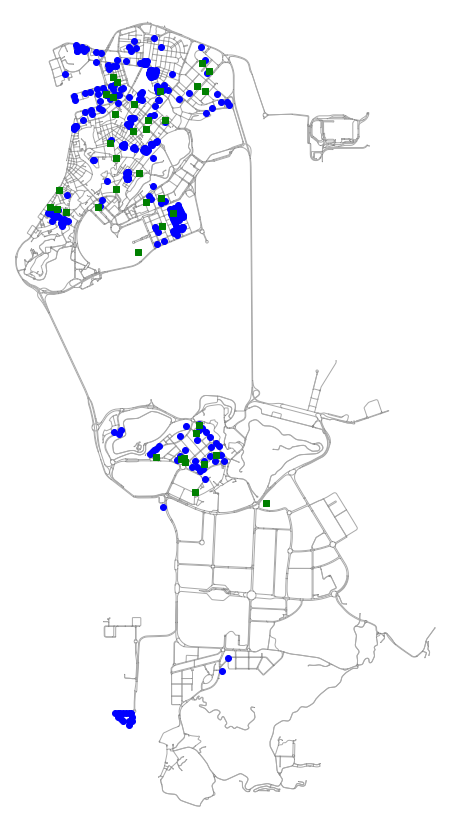

In [126]:
def one_epoch():
    sample_buildings = all_buildings.sample(1)
    new_SE_x = sample_buildings['center'].x
    new_SE_y = sample_buildings['center'].y
    dist = np.zeros(num_K)
    points = {}
    for n in range(num_N):
    #     nx, ny = all_buildings[n]['center'].x, all_buildings[n]['center'].y
        node_building = node_buildings[n]
        cloest_l = -1
        cloest_k = -1
        for k in range(num_K):
    #         kx, ky = all_schools[k]['center'].x, all_schools[k]['center'].y
    #         l = shortest_path(node_buildings[n], node_schools[k])
            if k < num_K -1:
                node_school = node_schools[k]
                if nx.has_path(G, node_building, node_school):
                    l = nx.shortest_path_length(G, source=node_building, target=node_school)
                    if cloest_k == -1 or l < cloest_l:
                        cloest_k = k
                        cloest_l = l
            else:
                node_school = ox.distance.nearest_nodes(G,X=new_SE_x,Y=new_SE_y)[0]
                if nx.has_path(G, node_building, node_school):
                    l = nx.shortest_path_length(G, source=node_building, target=node_school)
                    if cloest_k == -1 or l < cloest_l:
                        cloest_k = k
                        cloest_l = l
        if cloest_k != -1:
            # dist
            dist[cloest_k] += cloest_l
            # points
            if cloest_k not in points.keys():
                points[cloest_k] = []
            points[cloest_k].append(n)
    return dist, points
list_sum_dist = []
for i in range(1):
    dist, points = one_epoch()
    print(dist, points)    
    fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    for k in points:
        if k < num_K -1:
            ax.scatter(
                all_schools['center'][k].x,   
                all_schools['center'][k].y,   
                c='g',    
                marker="s",
                alpha=1,
                zorder=4
            )
        else:
            ax.scatter(
                new_SE_x,   
                new_SE_y,   
                c='g',    
                marker="s",
                alpha=1,
                zorder=4
            )
        ax.scatter(
            all_buildings['center'][points[k]].x, 
            all_buildings['center'][points[k]].y, 
            c='blue',            
            alpha=1,
            zorder=3
        )
    list_sum_dist.append(np.sum(dist))
print(list_sum_dist)

In [120]:
print(all_buildings['center'][[1,3]])

element_type  osmid    
way           192179943    POINT (113.55238 22.18877)
              192179954    POINT (113.55210 22.18943)
Name: center, dtype: geometry
